# Bounding configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [1]:
import copy

import numpy as np

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


In [2]:
# def progn(*args):
#     for arg in args:
#         arg()

# def prog2(out1, out2): 
#     return partial(progn,out1,out2)

# def prog3(out1, out2, out3):     
#     return partial(progn,out1,out2,out3)

# def if_then_else(condition, out1, out2):
#     out1() if condition() else out2()



In [284]:
from OCC.gp import gp_Pnt
from airconics.base import AirconicsShape, AirconicsCollection
from airconics import LiftingSurface, Fuselage, Engine
from OCC.gp import gp_Ax2
import OCC
from airconics import AirCONICStools as act
from OCC.BRepPrimAPI import BRepPrimAPI_MakeBox
import pydot
import types


class TreeNode(object):
    def __init__(self, part, name, arity):
        """Basic type to define node elements in the topology tree. To be used
        by Topology class.

        Parameters
        ----------
        part - Airconics type Fuselage, LiftingSurface or Engine
            The type to convert

        name - string
            The name of the part (e.g. 'Wing' or 'Fin')

        arity - int
            the number of descendants

        Attributes
        ----------
        arity - int
            arity (number of descendants) of this node.

        name - string
            Name of the part

        func - string
            Indicates the type of node i.e.
        """
        self.name = name
        self.arity = arity

        if type(part) not in FUNCTIONS.values():
            raise TypeError("Not a recognised part type: {}. Should be {}"
                .format(type(part), FUNCTIONS.values()))
        else:
            func_str = FUNCTIONS_INV[type(part)]
        self.func = func_str

    def __str__(self):
        output = '({}, {}, {})'.format(self.name, self.func, self.arity)
        return output


# Create a simple Box class that inherits from AirconicsShape
#  - this will behave similarly to the Engine, Fuselage class etc.
class Box(AirconicsShape):
    def __init__(self, xmin, ymin, zmin, dx, dy, dz):
        # This implicitly calls build
        super(Box, self).__init__(construct_geometry=True,
                                             xmin=xmin,
                                             ymin=ymin,
                                             zmin=zmin,
                                             dx=dx,
                                             dy=dy,
                                             dz=dz)
        
        
        xmin, ymin, zmin, xmax, ymax, zmax = self.Extents()
        self.xmin = xmin
        self.ymin = ymin
        self.zmin = zmin
        self.xmax = xmax
        self.ymax = ymax
        self.zmax = zmax
        
        directions = []
        
    def Build(self):
        Xmin = gp_Pnt(self.xmin, self.ymin, self.zmin)
        Xmax = gp_Pnt(self.xmin + self.dx, self.ymin + self.dy, self.zmin + self.dz)
        self['Box'] = BRepPrimAPI_MakeBox(Xmin, Xmax).Shape()

        
# This dictionary will be used for topology tree formatting
FUNCTIONS = {'E': Fuselage,         # E = Enclosure
             'L': LiftingSurface,   # L = Lifting Surface
             'P': Engine,           # P = Propulsion
             '|': gp_Ax2,           # M = Mirror Plane
             'B': Box,
             '': None}

# Reversed dictionary for manually adding shapes, i.e. converting
#  a class instance to a string
FUNCTIONS_INV = {func: name for name, func in FUNCTIONS.items()}

# The shapes of nodes in the exported graph from Topo class:
NODE_PROPERTIES = {Fuselage: {'shape': 'ellipse', 'fill':'#136ed4'},
          LiftingSurface: {'shape': 'box','fill':'#136ed4'},
          Engine: {'shape': 'hexagon', 'fill':'#136ed4'},
          gp_Ax2: {''},         # variables here are not used: mirror is a special case
          Box: {'shape': 'box', 'fill':'#136ed4'},
          types.NoneType : {'shape': 'point'},
          float: {'shape': 'ellipse'},
          int: {'shape': 'ellipse'}
         }


class BoxLayout(AirconicsCollection):
    def __init__(self):
        """maxcompoents is the number of components"""
        super(BoxLayout, self).__init__(parts={}, construct_geometry=True)
        
        # Carry around the tree for visualisation purposes:
        self._Tree = []
        self._deap_Tree = None   # This will be populated when 
        
        # Start with a simple box
        self.nparts = 0
        self.routine = None
    
    def __setitem__(self, name, part_w_arity):
        """Overloads the assignment operator used by AirconicsCollection
        to allow only tuples as inputs - arity must be specified for
        topology.

        Parameters
        ----------
        name - string
        part_w_arity - tuple
            (Airconics class, int), eg: (Fuselage, 2) is a Fuselage shape with
            2 descendents in its topological tree

        Notes
        -----
        appends to the self.Tree and self._OrderedParts attributes
        """
        try:
            part, arity = part_w_arity
        except:
            print("Warning: no arity set. Treating as zero")
            part = part_w_arity
            arity = 0

        node = TreeNode(part, name, arity)

        self._Tree.append(node)
        super(BoxLayout, self).__setitem__(name, part)
    
    def run(self, tree, pset):
        self._reset()
        routine = gp.compile(tree, pset)
        self._deap_Tree = tree
        routine()

    def _reset(self):
        self._Parts = {}
        self._Tree = []
        self._deap_Tree = None
        self.nparts = 0

    def boxN(self, xmin, ymin, zmin, dx, dy, dz, *args):
        # Fits N new components to this box layout
        box = Box(xmin, ymin, zmin, dx, dy, dz)
        self.nparts += 1
        # Do no be confused between the numbering of boxes and the number of descendent
        #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
        #  other shapes in this layout that are also named box0
        self['box{}_{}'.format(len(args), self.nparts)] = box, len(args)
        for arg in args:
            arg()

    # Now we need to explicitly add the box1, box2, .... boxM functions,
    # So that they can be added to the GP toolbox
    def box0(self, xmin, ymin, zmin, dx, dy, dz):
        return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz)
        
    def box1(self, xmin, ymin, zmin, dx, dy, dz, out1):
        return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz, out1)

    def box2(self, xmin, ymin, zmin, dx, dy, dz, out1, out2):
        return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz, out1, out2)
    
    def temp_fitness(self):
        """Until I come with something useful, the fitness evaluation for this
        configuration will be based on the bounding box volume"""
        try:
            xmin, ymin, zmin, xmax, ymax, zmax = self.Extents()
        except:
            # Bounding Box was probably void
            return 0
        return (xmax-xmin) * (ymax-ymin)*(zmax-zmin)
    
    def pydot_graph(self):
        """Returns a pydot graph instance of a human readable interpretation of
        the topology tree"""
        # Use the _deap_Tree if one is available (stored on calling run(tree, pset)):
        if self._deap_Tree:
            # Note: ns below is a simple range list for every edge/label
            ns, edges, labels = gp.graph(self._deap_Tree)
        else:
            raise AttributeError("No DEAP GP tree was found: see Box_Layout.run(tree, pset)")
        
        mirror_flag = False
        
        graph = pydot.Dot(splines='ortho', ranksep='0.1')
        graph.set_node_defaults(style='filled')
        graph.set_edge_defaults(arrowhead='none')

        cluster_1 = pydot.Cluster('standard', color='invis')
        graph.add_subgraph(cluster_1)
        
        # Check if a mirror plane exists in the geometry (affects tree visualisation)
        if any(isinstance(component, gp_Ax2) for component in self.values()):
            cluster_2 = pydot.Cluster('mirrored', label='mirrored', style='dashed')
            graph.add_subgraph(cluster_2)
        
        for node in nodes:
            # note: this only works because the node number is manually added
            # to the label by boxn:
            print(node)
            try:
                label = "{}_{}".format(labels[node], node+1)
                print(label)
                node_type = type(self[label])
                
                if isinstance(self[label], gp_Ax2):
                    # Everything below here is mirrored, so switch on mirror_flag
                    mirror_flag = True
                    # Also retrieve the index of the mirror, as edges will be removed
                    i_mirror = node

            except KeyError:
                # If we get here, the node is not an AirconicsShape: get the return type
                # using the deap tree
                node_type = self._deap_Tree[node].ret
                try:
                    label = "{:.4f}".format(labels[node])
                except ValueError:
                    # if the formatting failed, it's probably a function name (str)
                    label = labels[node]
                
            pydot_node = pydot.Node(node, label=label, **NODE_PROPERTIES[node_type])
            
            if mirror_flag:
                cluster_2.add_node(pydot_node)
            
            else:
                cluster_1.add_node(pydot_node)
    
        # Remove all (src, dest) edge from the list of edges if one of them
        # points to/from the mirror node
        if mirror_flag:
            edges = [edge for edge in edges if i_mirror not in edge]
        
        for edge in edges:
            src, dest = edge
            pydot_edge = pydot.Edge(src, dest)
            graph.add_edge(pydot_edge)

        return graph


In [285]:
config = BoxLayout()
import types, itertools, functools
funct = types.FunctionType
part = functools.partial
nt = types.NoneType

pset = gp.PrimitiveSetTyped("MAIN", [], nt)


pset.addPrimitive(config.box0, [float, float, float, float, float, float], nt)
pset.addPrimitive(config.box1, [float, float, float, float, float, float, nt], nt)
pset.addPrimitive(config.box2, [float, float, float, float, float, float, nt, nt], nt)
pset.addPrimitive(np.random.rand, [], float)

def useless_None():
    return None
pset.addTerminal(useless_None, nt)

pset.addEphemeralConstant('rand', np.random.rand, float)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=4)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalTopology(individual):
    # Transform the tree expression to functionnal Python code
    routine = gp.compile(individual, pset)
    # Run the generated routine
    global config
    config.run(routine)
    return config.temp_fitness(),
    
toolbox.register("evaluate", evalTopology)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def main():
    np.random.seed(69)
    
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 40, stats, halloffame=hof)
    
    return pop, hof, stats


Attempting to construct BoxLayout geometry...


In [286]:
# Try to compile a single individual and visualise both the tree and geometry
tree = toolbox.individual()
print(tree)


config.run(tree, pset)
print(config)


from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)

renderer

box2(rand(), rand(), rand(), rand(), rand(), rand(), box1(0.6098191649407781, 0.07332708538362209, 0.46772642132378806, 0.4799231617544014, 0.4056219895240323, 0.033473267705911414, useless_None), box2(0.6475131006391949, 0.4096917213986401, 0.7444926720382293, 0.32855965122147446, 0.1698158337494714, 0.5958645248592175, useless_None, useless_None))
['box1_2', 'box2_1', 'box2_3']


<TornadoWebRenderer at http://PChambers_ngcm:38943/get/8137a21124f3424ca21dce8ac9b44d0b>

0
box2_1
1
rand_2
2
rand_3
3
rand_4
4
rand_5
5
rand_6
6
rand_7
7
box1_8
8
0.609819164941_9
9
0.0733270853836_10
10
0.467726421324_11
11
0.479923161754_12
12
0.405621989524_13
13
0.0334732677059_14
14
useless_None_15
15
box2_16
16
0.647513100639_17
17
0.409691721399_18
18
0.744492672038_19
19
0.328559651221_20
20
0.169815833749_21


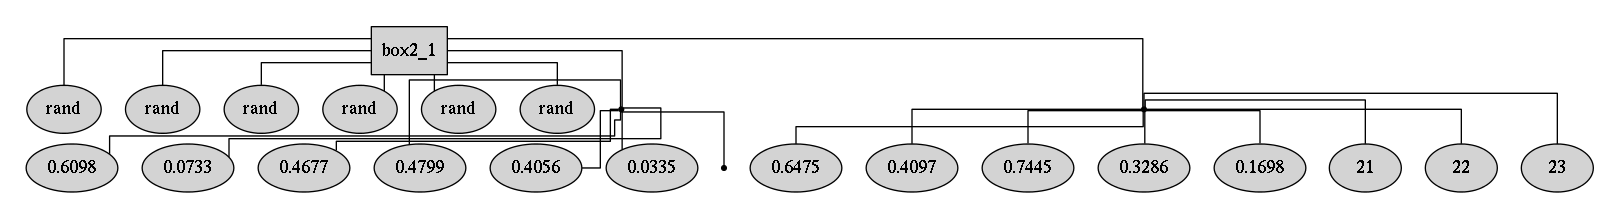

In [287]:
# Visualise the current tree:
from airconics import Topology
from IPython.display import Image

# nodes, edges, labels = gp.graph(tree)

# for edge in edges:
#     print(edge)

    
# print(edges)

# graph = pydot.Dot(type='digraph')
# help(pydot.Edge)
# cluster_1 = pydot.Cluster('standard', label='standard')
# for node in nodes:
#     pydot_node = pydot.Node(label, shape='box')
#     cluster_1.add_node()

# cluster_2 = pydot.Cluster('mirrored', label='mirrored')


# print(config.export_graphviz())

graph = config.pydot_graph()
Image(graph.create_png())


In [276]:
nodes, labels, edges = gp.graph(tree)
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [173]:
pop, hof, stats = main()

hof

TypeError: run() takes exactly 3 arguments (2 given)

In [7]:
best = hof[0]

nodes, edges, labels = gp.graph(best)
print(best)

routine = gp.compile(best, pset)
config.run(routine)

print(config)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)
renderer

box2(rand(), rand(), rand(), rand(), rand(), rand(), box2(rand(), rand(), rand(), rand(), rand(), rand(), box2(rand(), rand(), rand(), 0.7036617917548482, rand(), rand(), box2(0.8748633748188587, 0.5595595170406705, 0.9170047415837121, 0.4423162143316315, 0.3206571462359713, 0.19464673114229025, useless_None, useless_None), box2(0.49707731271128075, 0.9062991224568844, 0.5690672037124594, 0.359820411774053, 0.4956880350756393, 0.4119184433609153, useless_None, useless_None)), box0(rand(), rand(), rand(), rand(), rand(), rand())), box2(rand(), rand(), rand(), rand(), rand(), rand(), box2(rand(), rand(), rand(), rand(), rand(), rand(), box0(0.4958887344990667, 0.4241292773949338, 0.8551895290463735, 0.49426737813893495, 0.25841518147387266, 0.23782133564114438), box2(0.17956034310096147, rand(), 0.578854630578671, 0.41733522546876556, 0.8151192627896259, 0.031054394032625998, useless_None, useless_None)), box2(rand(), rand(), rand(), rand(), rand(), rand(), box1(0.5791585008689591, 0.403

<TornadoWebRenderer at http://PChambers_ngcm:45262/get/f16f1066a47d45c7944a1abb2127e001>

In [ ]:
# Visualise the best tree:
